In [1]:
from ipywidgets import interact

# Modeling a stake pool using [cToken](https://docs.compound.finance/v2/ctokens/#ctokens) for calculating rewards.

In [2]:
class Pool():
    def __init__(self, init_staked=0, init_lsd_supply=0) -> None:
        self.net_rewards = 0
        self.staked = init_staked
        self.lsd_supply = init_lsd_supply
    
    def total_eth(self):
        return self.staked + self.net_rewards
    
    def conversion_rate(self):
        return 0 if self.lsd_supply == 0 else self.total_eth() / self.lsd_supply

    def accrue(self, eth_amount):
        self.net_rewards += eth_amount
        return self.net_rewards, self.conversion_rate()

    def wrap(self, eth_amount, is_noop=False):
        rate_before = self.conversion_rate()
        lsd = eth_amount / rate_before
        self.staked += eth_amount
        self.lsd_supply += lsd
        return lsd, rate_before, self.conversion_rate()

    def unwrap(self, lsd_amount):
        rate_before = self.conversion_rate()
        eth_amount = lsd_amount * rate_before
        self.staked -= eth_amount
        self.lsd_supply -= lsd_amount
        return eth_amount, rate_before, self.conversion_rate()
    
    def penalize(self, eth_amount):
        self.staked -= eth_amount
        return self.staked, self.conversion_rate()

    def slash(self, eth_amount, lsd_amount):
        self.staked -= eth_amount
        self.lsd_supply -= lsd_amount
        return self.staked, self.conversion_rate()
    
    def print_state(self):
        print(f'({self.staked} ETH staked + {self.net_rewards} ETH rewards) / {self.lsd_supply} total pufETH = {self.conversion_rate()}')

In [3]:
init_staked = 100
init_lsd_supply = 100
p = Pool(init_staked=init_staked, init_lsd_supply=init_lsd_supply)
p.conversion_rate()
for i in range(10):
    print(p.accrue(10))


(10, 1.1)
(20, 1.2)
(30, 1.3)
(40, 1.4)
(50, 1.5)
(60, 1.6)
(70, 1.7)
(80, 1.8)
(90, 1.9)
(100, 2.0)


In [4]:
class Staker():
    def __init__(self, init_eth=0.0, name='alice') -> None:
        self.name = name
        self.init_eth: float = init_eth
        self.eth: float = init_eth
        self.lsd = 0.0
        self.rewards = 0.0
        self.conversion_rate_in: float = None
        self.conversion_rate_out: float = None

    def stake(self, eth_amount, p: Pool):
        assert self.eth >= eth_amount
        # lsd, self.conversion_rate_in = p.wrap(eth_amount)
        lsd, rate_before, rate_after = p.wrap(eth_amount)
        self.eth -= eth_amount
        self.lsd += lsd
        print(f'{self.name} staked {eth_amount} ETH <-> {rate_before} rate <-> {lsd} pufETH')
        return lsd, rate_before, rate_after

    def unstake(self, lsd_amount, p: Pool):
        assert self.lsd >= lsd_amount
        eth, rate_before, rate_after = p.unwrap(lsd_amount)
        self.eth += eth
        self.lsd -= lsd_amount
        print(f'{self.name} unstaked {lsd_amount} pufETH <-> {rate_before} rate <-> {eth} ETH')
        return eth, rate_before, rate_after


# Verifying cToken scenario from [cbETH whitepaper](https://www.coinbase.com/cbeth/whitepaper?__cf_chl_f_tk=RxLsPF3viPE8LQtTJoBUS2X0D6j2oKqjxeJHdJHL9SQ-1670951819-0-gaNycGzNDKU)

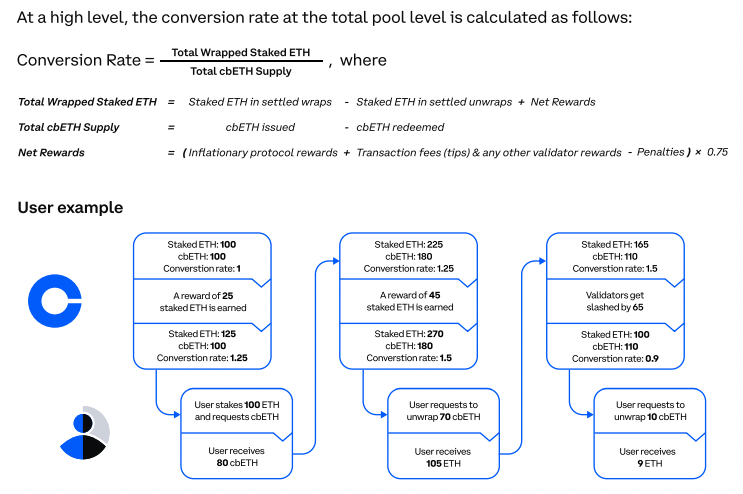

In [5]:
init_staked = 100
init_lsd_supply = 100
staker_init_eth = 100
p = Pool(init_staked=init_staked, init_lsd_supply=init_lsd_supply)
p.print_state()
a = Staker(init_eth=staker_init_eth, name='alice')

p.accrue(25)
p.print_state()

a.stake(100, p)
p.print_state()

p.accrue(45)
p.print_state()

a.unstake(70, p)
p.print_state()

p.penalize(65)
p.print_state()

a.unstake(10, p)
p.print_state()

(100 ETH staked + 0 ETH rewards) / 100 total pufETH = 1.0
(100 ETH staked + 25 ETH rewards) / 100 total pufETH = 1.25
alice staked 100 ETH <-> 1.25 rate <-> 80.0 pufETH
(200 ETH staked + 25 ETH rewards) / 180.0 total pufETH = 1.25
(200 ETH staked + 70 ETH rewards) / 180.0 total pufETH = 1.5
alice unstaked 70 pufETH <-> 1.5 rate <-> 105.0 ETH
(95.0 ETH staked + 70 ETH rewards) / 110.0 total pufETH = 1.5
(30.0 ETH staked + 70 ETH rewards) / 110.0 total pufETH = 0.9090909090909091
alice unstaked 10 pufETH <-> 0.9090909090909091 rate <-> 9.09090909090909 ETH
(20.90909090909091 ETH staked + 70 ETH rewards) / 100.0 total pufETH = 0.9090909090909091


In [6]:
init_staked = 100
init_lsd_supply = 100
staker_init_eth = 100
p = Pool(init_staked=init_staked, init_lsd_supply=init_lsd_supply)
p.print_state()
a = Staker(init_eth=staker_init_eth, name='alice')
b = Staker(init_eth=staker_init_eth, name='bob')

p.accrue(25)
p.print_state()

a.stake(100, p)
p.print_state()

p.accrue(45)
p.print_state()

b.stake(100, p)
p.print_state()

p.accrue(60)
p.print_state()

a.unstake(a.lsd, p)
p.print_state()

b.unstake(b.lsd, p)
p.print_state()

(100 ETH staked + 0 ETH rewards) / 100 total pufETH = 1.0
(100 ETH staked + 25 ETH rewards) / 100 total pufETH = 1.25
alice staked 100 ETH <-> 1.25 rate <-> 80.0 pufETH
(200 ETH staked + 25 ETH rewards) / 180.0 total pufETH = 1.25
(200 ETH staked + 70 ETH rewards) / 180.0 total pufETH = 1.5
bob staked 100 ETH <-> 1.5 rate <-> 66.66666666666667 pufETH
(300 ETH staked + 70 ETH rewards) / 246.66666666666669 total pufETH = 1.4999999999999998
(300 ETH staked + 130 ETH rewards) / 246.66666666666669 total pufETH = 1.7432432432432432
alice unstaked 80.0 pufETH <-> 1.7432432432432432 rate <-> 139.45945945945945 ETH
(160.54054054054055 ETH staked + 130 ETH rewards) / 166.66666666666669 total pufETH = 1.743243243243243
bob unstaked 66.66666666666667 pufETH <-> 1.743243243243243 rate <-> 116.21621621621621 ETH
(44.32432432432434 ETH staked + 130 ETH rewards) / 100.00000000000001 total pufETH = 1.743243243243243


## [Calculating the slashing penalty](https://github.com/ethereum/annotated-spec/blob/master/phase0/beacon-chain.md#registry-updates):

```There are also longer units of time; by convention, a period of 2048 epochs (~9.1 days) is called an eek ("ethereum week"); some operations on the beacon chain that take a long time can be measured in eeks.```

...

```Proportional slashing penalties: if you get slashed, you lose 3s/D of your deposit, where s is the total ETH of other validators that got slashed in the time period between 2 eeks before you were slashed and 2 eeks after you are slashed, and D is total deposits. For example, if there is 10 million ETH staking, you get slashed, and 300,000 ETH worth of validators got slashed within 2 eeks of you, you lose 9% of your deposit (this is in addition to the fixed 1/32 minimum penalty).```

### Takeaway:
- the only way to lose 32 ETH during a slashing is if 1/3 of the network was also slashed within ~18.2 days!

In [7]:
def calc_slashing_penalty(slashable_eth, eth_staked):
    perc = 3 * slashable_eth / eth_staked
    return 1  + perc * 32

In [8]:
assert calc_slashing_penalty(300_000, 10_000_000) == 1 + 32 * 0.09

# Risks
> We want to model Puffer's risk in the worst case scenario where an adversary manages to break SGX and self-slash.


## Example Shorting Attack
- Malice borrows pufETH on a lending platform (e.g., Aave).

- Malice either trades the pufETH for ETH on a DEX or redeems ETH from the Puffer pool directly by burning the pufETH (post-Shanghai).

- Malice uses this ETH to instanstiate $N$ NoOps, dedicates the resources to breaking SGX to uncover all validator keys, then causes a mass self-slashing event.

- Depending on the amount of ETH capital used, Malice could slash [$N$, 32*$N$] of the pool's ETH.

- The decrease in the pool's staked ETH will ultimately decrease the value of pufETH relative to ETH.

- Since Malice's original loan was in pufETH which has decereased in price, the amount that they pay back will be less.

In [ ]:
# total eth staked today
total_eth_staked = 15.6e6 

@interact(market_perc_captured=(1, 20, 0.1), noop_collateral=(1, 32, 0.1), burst_threshold=(1, 20, 0.1))
def short_attack(market_perc_captured=10.0, noop_collateral=2.0, burst_threshold=20.0):
    market_perc_captured /= 100
    burst_threshold /= 100
    assert market_perc_captured <= burst_threshold
    init_pool_eth = total_eth_staked * market_perc_captured
    remaining_capturable_eth = total_eth_staked * (burst_threshold - market_perc_captured)
    remaining_validator_keys = remaining_capturable_eth / 32

    # parameter for the starting conversion rate
    expected_init_conv_rate = 1.14

    # init a pool with 1.0 conversion rate
    p = Pool(init_staked=init_pool_eth, init_lsd_supply=init_pool_eth)
    print(f'Assume Puffer controls {100*market_perc_captured:0.2f}% of the {total_eth_staked/1e6}M ETH staked,')
    print(f'with a burst threshold of {100*burst_threshold:0.2f}%, the pool can grow by {remaining_capturable_eth} ETH.')
    print(f'This allows the pool to onboard {round(remaining_validator_keys)} new validators.')

    # get the pool to the expected initial state
    p.accrue(p.total_eth() * (expected_init_conv_rate - 1))
    p.print_state()

    # DVT parameters dvt_sigs / noops_per_minipool
    dvt_sigs = 1
    noops_per_minipool = 1

    # how much ETH is required to corrupt a minipool
    eth_to_control_a_minipool = noop_collateral * dvt_sigs
    required_attacker_eth = remaining_validator_keys * eth_to_control_a_minipool

    print(f'With {noop_collateral} ETH NoOp collateral, an attacker requires {eth_to_control_a_minipool} ETH to control a minipool with {dvt_sigs}/{noops_per_minipool} DVT threshold')
    print(f"To control every new minipool, an attacker needs at least {round(required_attacker_eth)} ETH capital.")

    # attacker borrows enough pufETH so that they swap/trade it for required_attacker_eth
    # since price of ETH < price of pufETH, they need to borrow less pufETH than the ETH amount to pull off the attack
    attacker_capital_eth = required_attacker_eth * 1.5 # requires 150% collateral to borrow on Aave
    attacker_borrowed_pufETH = attacker_capital_eth / 1.5 / p.conversion_rate() # 150% loan on Aave, and use conversion rate to get approx pufETH for this amount eth
    print(f'With {attacker_capital_eth:.2f} ETH, the attacker can borrow {attacker_borrowed_pufETH:.2f} pufETH on Aave (150% collateral) at the given ETH:pufETH rate: {p.conversion_rate()}')
    print(f'(we are assuming there is this much pufETH available to borrow on Aave)')

    # attack converts pufETH to ETH (either by swapping w/ Puffer or trading on DEX)
    attacker_eth = attacker_borrowed_pufETH * p.conversion_rate() 
    print(f'Attacker trades {attacker_borrowed_pufETH:.2f} pufETH <-> {attacker_eth:.2f} ETH (e.g., on Uniswap)')

    # this is how much staker ETH the attacker threatens
    attacker_minipools = attacker_eth / eth_to_control_a_minipool
    staker_threatened_eth = attacker_minipools * (32 - noop_collateral * noops_per_minipool)
    print(f'-------- Begin attack --------')
    print(f'Attacker spins up {round(attacker_minipools)} minipools (we assume the required {staker_threatened_eth:.2f} staker ETH liquidity is available')

    # mint this much pufETH for stakers
    staker_pufETH, _, _ = p.wrap(staker_threatened_eth)
    print(f'Stakers convert {staker_threatened_eth:.2f} ETH <-> {staker_pufETH:.2f} pufETH')
    # p.print_state()

    # the NoOp LSD is minted but locked as collateral
    attacker_collateral = attacker_minipools * noop_collateral * noops_per_minipool
    attacker_pufETH, _, rate_before = p.wrap(attacker_collateral)
    print(f'Attacker locks their {attacker_collateral:.2f} ETH collateral and receieves {attacker_pufETH:.2f} locked pufETH')
    # p.print_state()

    # attack performs attack
    total_threatened_eth = staker_threatened_eth + attacker_collateral
    print(f'Attacker slashes {attacker_minipools:.2f} minipools -> threatening {attacker_collateral:.2f} ETH of their own and {staker_threatened_eth:.2f} ETH from stakers (total = {total_threatened_eth:.2f} ETH)')
    slash_amt_per_minipool = calc_slashing_penalty(slashable_eth=total_threatened_eth, eth_staked=total_eth_staked)
    amount_slashed = slash_amt_per_minipool * attacker_minipools
    staker_damage = max(amount_slashed - attacker_collateral, 0)
    print(f'Each minipool will lose {slash_amt_per_minipool:.2f}/32 ETH or {100*slash_amt_per_minipool/32:.2f}% of its ETH')
    eth, rate_after = p.slash(eth_amount=amount_slashed, lsd_amount=attacker_pufETH)

    print(f'The pool lost {amount_slashed:.2f} ETH')
    print(f'Attacker lost {attacker_minipools * eth_to_control_a_minipool:.2f} ETH')
    honest_noops_per_minipool = noops_per_minipool - dvt_sigs 
    if honest_noops_per_minipool > 0:
        print(f'Victim noops lost {attacker_minipools * noop_collateral * honest_noops_per_minipool:.2f} ETH')
    print(f'stakers lost {staker_damage:.2f} ETH')
    print(f'attack decreased pools conversion rate by {rate_before:0.3f} - {rate_after:0.3f} = {rate_before - rate_after:0.3f}')
    p.print_state()

    new_eth_loan_amount = attacker_borrowed_pufETH * rate_after
    amount_eth_change = attacker_borrowed_pufETH * rate_before - new_eth_loan_amount
    perc_loan_reduction = (attacker_capital_eth - amount_eth_change) / attacker_capital_eth
    print('\nsummary:')
    print(f'The attacker locked their {attacker_capital_eth:.2f} ETH as collateral to initially borrow {attacker_borrowed_pufETH:.2f} pufETH on Aave (150% collateralized), which was redeemable at the time for {attacker_borrowed_pufETH * rate_before:.2f} ETH.')
    print(f'After slashing the {attacker_minipools:.2f} Puffers, the attacker decreased the pools conversion rate by {rate_before - rate_after:0.3f}.')
    print(f'This decreases the price of ETH:pufETH, meaning the original borrowed pufETH is now redeemable for {new_eth_loan_amount:.2f} ETH, ({amount_eth_change:.2f} ETH less).')
    print(f'To get back their ETH collateral on Aave, the attacker would only need to pay back {attacker_capital_eth - amount_eth_change:.2f} ETH, or {100*perc_loan_reduction:0.3f}% of their initial collateral')
    usd_per_eth = 1300
    print(f'@ ${usd_per_eth}/ETH, the attacker would have paid ${attacker_capital_eth * usd_per_eth / 1e6:0.3f}M to reduce their loan amount by {100*(1-perc_loan_reduction):0.3f}%, putting them ${attacker_capital_eth * usd_per_eth * perc_loan_reduction / 1e6:0.3f}M in debt')


# Results:
- For every 1% of the total supply of ETH that an adversary tries to slash, it will burn 1 + 32*0.03 = 1.96 ETH per validator.

- At the price of 
9.5M and would only reduce their loan amount by 0.162% (~$15,000).

- Increasing the NoOp collateral to 2 ETH will mean that none of the pool's ETH can be threatened if the attack is 
 1% of all of ETH staked.

In [ ]:
# total eth staked today
total_eth_staked = 15.6e6 
usd_per_eth = 1500
burst_threshold = 0.20
print(f'Assume there is {total_eth_staked / 1e6}M ETH staked')

@interact(C=(1, 32, 0.1), M=(1, 10), N=(1, 10), staker_griefing_rate=(0, 1.0, 0.01))
def model_griefing(C=2.0, M=1, N=1, staker_griefing_rate=0.0):
    '''C: noop collateral, M: threshold num dvt sigs, N: dvt cluster size, where M/N sigs needed to sign via DVT'''
    assert M <= N

    attacker_collateral = C * M
    minipool_collateral = C * N
    print(f'With {M}/{N} DVT, and C={C} ETH NoOp collateral, an attacker requires {attacker_collateral} ETH to corrupt a Minipool with {minipool_collateral} total ETH collateral')

    # calc damages (https://github.com/ethereum/annotated-spec/blob/master/phase0/beacon-chain.md#registry-updates)
    def calc_eth_to_attack(exp_p, e):
        # S is the min staked eth that needs to be slashed to achieve expected penalty `exp_p` in ETH
        # exp_p = 1 + (3*S / total_eth_staked) * 32
        # (exp_p - 1) / 32 = 3*S / total_eth_staked
        # ((exp_p - 1) * total_eth_staked) / 32 = 3*S
        # (((exp_p - 1) * total_eth_staked) / 32) / 3 = S
        # (exp_p - 1) * total_eth_stacked / (32 * 3) = S
        S = (exp_p - 1) * e / (32 * 3) 
        return S 

    # calc how much ETH must be slashed at once to hurt stakers
    S = calc_eth_to_attack(exp_p=minipool_collateral, e=total_eth_staked)

    minipools_to_attack = round(S / 32)
    required_eth_to_attack = minipools_to_attack * attacker_collateral
    dollars_to_attack = required_eth_to_attack * usd_per_eth
    perc_of_total_eth_to_attack = S / total_eth_staked
    print(f"Reaching a slashing penalty this high requires the attacker to slash {S:.1f} ETH ({perc_of_total_eth_to_attack * 100:.2f}% of the total ETH staked) or {minipools_to_attack} minipools in a span of <= 2 eeks (~18 days).")
    print(f"To control the {minipools_to_attack} minipools, the attacker must sacrifice {required_eth_to_attack:.2f} ETH (${dollars_to_attack / 1e6:.1f}M @ ${usd_per_eth}/ETH) of their own capital.")

    honest_noop_loss = minipools_to_attack * (minipool_collateral - attacker_collateral)
    print(f"\n~~ At this point the attacker has griefed honest noops {honest_noop_loss} ETH (${honest_noop_loss * usd_per_eth / 1e6:.1f}M @ ${usd_per_eth}/ETH) but staker ETH is untouched ~~\n")

    if perc_of_total_eth_to_attack > burst_threshold:
        print(f'With a burstThreshold of {burst_threshold}, this attack is impossible')

    # the target amount of staker ETH the attacker is trying to slash from [0.0:1.0]
    assert staker_griefing_rate <= 1.0, "can't grief more ETH than stakers have!"
    staker_eth_to_lose = (32 - minipool_collateral) * staker_griefing_rate
    eth_to_lose_per_minipool = minipool_collateral + staker_eth_to_lose
    S = calc_eth_to_attack(exp_p=eth_to_lose_per_minipool, e=total_eth_staked)
    minipools_to_attack = S / 32
    required_eth_to_attack = minipools_to_attack * attacker_collateral
    dollars_to_attack = required_eth_to_attack * usd_per_eth
    perc_of_total_eth_to_attack = S / total_eth_staked
    print(f'A motivated attacker that wishes to slash {staker_griefing_rate*100}% of the stakers ETH would try to slash > {eth_to_lose_per_minipool:.4f} ETH per Minipool).')
    print(f"\tNote this is {staker_griefing_rate*100}% of staker ETH penalized in addition to 100% of each affected Minipool's collateral.")
    print(f"\tFor example, to grief 10% of staker ETH would attack 10% * (32 - {minipool_collateral}) = {(32-minipool_collateral)*0.1:0.1f} ETH per minipool.")
    print(f"Reaching a slashing penalty this high requires the attacker to slash {S:.1f} ETH ({perc_of_total_eth_to_attack * 100:.2f}% of the total ETH staked) or {round(minipools_to_attack)} minipools in a span of <= 2 eeks (~18 days).")

    pool_eth_lost = eth_to_lose_per_minipool * minipools_to_attack
    print(f'When the attacker performs this mass self-slashing on the {round(minipools_to_attack)} minipools, they wipe out {pool_eth_lost} ETH from the pool (${(pool_eth_lost * usd_per_eth)/1e6}M @${usd_per_eth}/ETH).')

    print(f"The attacker loses {required_eth_to_attack:.2f} ETH (${dollars_to_attack / 1e6:.1f}M @ ${usd_per_eth}/ETH) of their own capital.")
    honest_noop_loss = minipools_to_attack * (minipool_collateral - attacker_collateral)
    print(f"honest noops lose {honest_noop_loss} ETH (${honest_noop_loss * usd_per_eth / 1e6:.1f}M @ ${usd_per_eth}/ETH)")

    staker_eth_lost = staker_eth_to_lose * minipools_to_attack
    print(f"stakers lose {staker_eth_lost} ETH (${staker_eth_lost * usd_per_eth / 1e6:.1f}M @ ${usd_per_eth}/ETH)")

    attacker_leverage = (honest_noop_loss + staker_eth_lost) / required_eth_to_attack
    print(f'The result is the attacker paid 1 ETH for every {attacker_leverage:.2f} ETH they burned from stakers and honest noops.')

    if perc_of_total_eth_to_attack > burst_threshold:
        print(f'With a burstThreshold of {100*burst_threshold}%, this attack is impossible!')

A more basic/general model:

In [60]:
# calc damages (https://github.com/ethereum/annotated-spec/blob/master/phase0/beacon-chain.md#registry-updates)
def calc_eth_to_attack(exp_p, e):
    # S is the min staked eth that needs to be slashed to achieve expected slashing penalty of `exp_p` in ETH
    # exp_p = 1 + (3*S / total_eth_staked) * 32
    # (exp_p - 1) / 32 = 3*S / total_eth_staked
    # ((exp_p - 1) * total_eth_staked) / 32 = 3*S
    # (((exp_p - 1) * total_eth_staked) / 32) / 3 = S
    # (exp_p - 1) * total_eth_stacked / (32 * 3) = S
    S = (exp_p - 1) * e / (32 * 3) 
    return S 

def short_attack(
    total_eth_staked = 18.0e6,
    usd_per_eth = 2000,
    bond = 8.0,
    attacker_desired_penalty = 9.0
):
    assert attacker_desired_penalty <= 32.0 and attacker_desired_penalty > 1.0
    print(f'Assume there is {total_eth_staked / 1e6}M ETH staked')
    print(f'Assume for simplicity the entire validator set is one pool')
    print(f"Assume the ratio of LSD:ETH is 1:1")
    print(f'Assume {bond} ETH NoOp bond')
    print(f'Assume attacker wants to trigger a {attacker_desired_penalty} ETH correlated slashing penalty')
    print(f'Assume penalties are deducted from the attacker bond first, with only excess penalties harming the pool')

    # calc how much ETH must be slashed to reach the desired slashing penalty
    S = calc_eth_to_attack(exp_p=attacker_desired_penalty, e=total_eth_staked)
    perc_of_total_eth_to_attack = S / total_eth_staked
    noops_to_attack = round(S / 32)
    print(f"To reach a correlated slashing penalty of {attacker_desired_penalty} ETH, the attacker must slash {S:.1f} ETH ({perc_of_total_eth_to_attack * 100:.2f}% of the total ETH staked) or {noops_to_attack} NoOps in a span of 36 days.")

    # capital to attack
    required_eth_to_attack = noops_to_attack * bond
    dollars_to_attack = required_eth_to_attack * usd_per_eth
    print(f"To control the {noops_to_attack} NoOps, the attacker requires {required_eth_to_attack:.2f} ETH (${dollars_to_attack / 1e6:.1f}M @ ${usd_per_eth}/ETH) in capital.")

    # assume attacker takes a loan out at 1:1 with LSD
    lsd_minted = required_eth_to_attack
    eth_borrowed = lsd_minted

    # damage to the attacker
    attacker_eth_lost = min(noops_to_attack * attacker_desired_penalty, required_eth_to_attack)
    attacker_dollars_lost = attacker_eth_lost * usd_per_eth
    print(f"This attack would cost the attacker {attacker_eth_lost:.2f} ETH (${attacker_dollars_lost / 1e6:.1f}M @ ${usd_per_eth}/ETH).")

    # damage to the pool
    pool_eth_attacked = max(noops_to_attack * (attacker_desired_penalty - bond), 0)
    pool_dollars_attacked = pool_eth_attacked * usd_per_eth
    print(f"This attack would cost the pool {pool_eth_attacked:.2f} ETH (${pool_dollars_attacked / 1e6:.1f}M @ ${usd_per_eth}/ETH).")

    # attacker now returns loan 
    lsd_to_eth_ratio = (total_eth_staked - S) / total_eth_staked
    discount = 1.0 - lsd_to_eth_ratio
    dollars_less = discount * eth_borrowed * usd_per_eth
    profit = dollars_less - attacker_dollars_lost
    print(f"The LSD:ETH ratio decreased to {lsd_to_eth_ratio:.2f}:1 meaning the attacker's debt is reduced {discount * 100:.1f}% or ${dollars_less/1e6:0.1f}M")
    print(f"The attacker made a profit of ${profit / 1e6:0.1f}M")
    return profit


# total eth staked today
total_eth_staked = 18.0e6 
usd_per_eth = 2000
bond = 8.0
attacker_desired_penalty = 9.0

profit = short_attack(
    total_eth_staked,
    usd_per_eth,
    bond,
    attacker_desired_penalty,
)

Assume there is 18.0M ETH staked
Assume for simplicity the entire validator set is one pool
Assume the ratio of LSD:ETH is 1:1
Assume 8.0 ETH NoOp bond
Assume attacker wants to trigger a 9.0 ETH correlated slashing penalty
Assume penalties are deducted from the attacker bond first, with only excess penalties harming the pool
To reach a correlated slashing penalty of 9.0 ETH, the attacker must slash 1500000.0 ETH (8.33% of the total ETH staked) or 46875 NoOps in a span of 36 days.
To control the 46875 NoOps, the attacker requires 375000.00 ETH ($750.0M @ $2000/ETH) in capital.
This attack would cost the attacker 375000.00 ETH ($750.0M @ $2000/ETH).
This attack would cost the pool 46875.00 ETH ($93.8M @ $2000/ETH).
The LSD:ETH ratio decreased to 0.92:1 meaning the attacker's debt is reduced 8.3% or $62.5M
The attacker made a profit of $-687.5M
